# THItoGene Benchmark (INT25-INT28)

## 环境配置说明
建议创建一个新的 Conda 环境以避免依赖冲突：

### 1. 创建并激活新环境
```bash
conda create -n thitogene_bench python=3.9
conda activate thitogene_bench
```

### 2. 安装 PyTorch 和依赖
```bash
pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
pip install openslide-python pytorch-lightning scanpy pandas "numpy<2" matplotlib seaborn scprep scikit-learn tqdm einops
```

**注意**：Windows 用户需要手动下载 OpenSlide 二进制文件并将 `bin` 目录添加到环境变量。

---

## 任务描述
本 Notebook 用于在 HEST 数据集（INT25-INT28）上运行 THItoGene 模型。
- **训练集**: INT25, INT26
- **验证集**: INT27
- **测试集**: INT28


In [1]:
import os
import sys
import json
from pathlib import Path
import numpy as np
import pandas as pd
import h5py
import torch
import scanpy as sc
from PIL import Image

# 尝试修复 Windows 下 OpenSlide 找不到 DLL 的问题
if os.name == 'nt':
    conda_prefix = os.environ.get('CONDA_PREFIX')
    curr_python = sys.executable
    possible_paths = []
    if conda_prefix:
        possible_paths.append(Path(conda_prefix) / 'Library' / 'bin')
    if curr_python:
        possible_paths.append(Path(curr_python).parent / 'Library' / 'bin')
        possible_paths.append(Path(curr_python).parent / '..' / 'Library' / 'bin')
    
    for p in possible_paths:
        if p.exists() and ((p / 'libopenslide-1.dll').exists() or (p / 'libopenslide-0.dll').exists()):
            print(f"Found OpenSlide DLL at: {p}")
            try:
                os.add_dll_directory(str(p))
            except AttributeError:
                pass
            os.environ['PATH'] = str(p) + os.pathsep + os.environ['PATH']
            break

try:
    import openslide
    print("OpenSlide imported successfully!")
except ImportError as e:
    print(f"OpenSlide not found ({e}), will use PIL as fallback.")

from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# ====== 关键路径设置 ======
ROOT = Path(os.environ.get('MORPHO_VC_ROOT', '../')).expanduser().resolve()
print(f"ROOT: {ROOT}")

sys.path.append(str(ROOT / 'src'))
# 添加 THItoGene 源码路径
th_src = ROOT / 'benchmark' / 'THItoGene'
sys.path.append(str(th_src))
# 添加 benchmark 目录以导入 hest_dataset
sys.path.append(str(ROOT / 'benchmark'))

from vis_model import THItoGene
from hest_dataset import HESTTHItoGeneDataset

# 数据目录
data_dir = ROOT / 'data'
hest_dir = data_dir / 'hest_data'
spatial_dir = data_dir / 'spatial_data'
result_dir = ROOT / 'benchmark' / 'results' / 'thitogene'
result_dir.mkdir(parents=True, exist_ok=True)

# 共同基因列表
common_gene_path = spatial_dir / 'common_genes.txt'

# 切片 ID
train_ids = ['INT25', 'INT26']
val_ids = ['INT27']
test_ids = ['INT28']

print("Result Directory:", result_dir)

Found OpenSlide DLL at: C:\ProgramData\anaconda3\envs\thitogene_bench\Library\bin
OpenSlide imported successfully!
ROOT: D:\code\Morpho-VC
Result Directory: D:\code\Morpho-VC\benchmark\results\thitogene


## 1. 数据准备
加载共同基因并创建 DataLoader。

In [2]:
# ??????
with open(common_gene_path, 'r') as f:
    common_genes = f.read().splitlines()
print(f"Common genes count: {len(common_genes)}")


def _require_array_coords(spatial_dir, slide_ids):
    missing = []
    for sid in slide_ids:
        h5ad_path = spatial_dir / f"{sid}.h5ad"
        with h5py.File(h5ad_path, "r") as f:
            if "array_col" not in f["obs"] or "array_row" not in f["obs"]:
                missing.append(sid)
    if missing:
        raise ValueError(
            "Missing array_row/array_col in slides: "
            f"{missing}. THItoGene positional embeddings require discrete grid indices."
        )


def _infer_n_pos(spatial_dir, slide_ids):
    # Strict mode: require array coords for all slides.
    _require_array_coords(spatial_dir, slide_ids)
    max_col = 0
    max_row = 0
    for sid in slide_ids:
        h5ad_path = spatial_dir / f"{sid}.h5ad"
        with h5py.File(h5ad_path, "r") as f:
            col = f["obs"]["array_col"][:]
            row = f["obs"]["array_row"][:]
            col = col - col.min()
            row = row - row.min()
            max_col = max(max_col, int(col.max()))
            max_row = max(max_row, int(row.max()))
    return max(max_col, max_row) + 1

BATCH_SIZE = 1 # THItoGene ?????? Slide ???? Graph??? batch_size=1
PATCH_SIZE = 112
N_POS = _infer_n_pos(spatial_dir, train_ids + val_ids + test_ids)
print(f"Inferred N_POS: {N_POS}")


print("Loading Train Dataset...")
train_ds = HESTTHItoGeneDataset(train_ids, hest_dir, spatial_dir, common_genes, patch_size=PATCH_SIZE, n_pos=N_POS, train=True)
print("Loading Val Dataset...")
val_ds = HESTTHItoGeneDataset(val_ids, hest_dir, spatial_dir, common_genes, patch_size=PATCH_SIZE, n_pos=N_POS, train=True)
print("Loading Test Dataset...")
test_ds = HESTTHItoGeneDataset(test_ids, hest_dir, spatial_dir, common_genes, patch_size=PATCH_SIZE, n_pos=N_POS, train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Common genes count: 17512
Inferred N_POS: 128
Loading Train Dataset...
Loading 2 slides for THItoGene...
Loading Val Dataset...
Loading 1 slides for THItoGene...
Loading Test Dataset...
Loading 1 slides for THItoGene...


## 2. 模型训练
初始化 THItoGene 模型并进行训练。
注意：由于显存限制，如果遇到 OOM，可能需要减小 patch_size 或调整模型参数。

为了防止报错重写efficent_capsnet.py文件中的方法，修改内容为：“c = c / torch.sqrt(torch.tensor([self.dim_capsules], device=c.device, dtype=c.dtype))”

In [3]:
checkpoint_callback = ModelCheckpoint(
    monitor='valid_loss',
    dirpath=result_dir,
    filename='thitogene_best',
    save_top_k=1,
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor="valid_loss",
    min_delta=0.00,
    patience=10,
    verbose=True,
    mode="min"
)

# 训练配置
max_epochs = 300
learning_rate = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_model_path = result_dir / 'thitogene_best.ckpt'
train_model = False

if best_model_path.exists():
    print(f"Found existing checkpoint at {best_model_path}. Loading...")
    try:
        model = THItoGene.load_from_checkpoint(
            str(best_model_path),
            n_genes=len(common_genes),
            learning_rate=learning_rate,
            route_dim=64,
            caps=20,
            heads=[16, 8],
            n_layers=4,
            n_pos=N_POS,
            patch_size=PATCH_SIZE
        )
        print("Checkpoint loaded successfully. Skipping training.")
        train_model = False
    except Exception as e:
        print(f"Load failed ({e}). Re-training.")
else:
    print("No checkpoint found. Training new model.")

if train_model:
    # 初始化模型
    model = THItoGene(
        n_genes=len(common_genes),
        learning_rate=learning_rate,
        route_dim=64,
        caps=20,
        heads=[16, 8],
        n_layers=4,
        n_pos=N_POS,
        patch_size=PATCH_SIZE
    )
    
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=[checkpoint_callback, early_stop_callback],
        default_root_dir=result_dir,
        log_every_n_steps=1
    )
    
    print("Starting training...")
    trainer.fit(model, train_loader, val_loader)


Found existing checkpoint at D:\code\Morpho-VC\benchmark\results\thitogene\thitogene_best.ckpt. Loading...
Checkpoint loaded successfully. Skipping training.


## 3. 预测与评估
加载最佳模型并在测试集（INT28）上进行预测，计算指标。

In [4]:
# if train_model and best_model_path.exists():
    
# Always load the trained model before prediction.
model = THItoGene.load_from_checkpoint(
    str(best_model_path),
    n_genes=len(common_genes),
    n_pos=N_POS,
    patch_size=PATCH_SIZE,
)

model.eval()
model.to(device)

preds_list = []
true_list = []
coords_list = []

preds_by_slide = {}
true_by_slide = {}
coords_by_slide = {}
slide_order = []

print("Predicting on Test set...")
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        sid = test_ds.slide_ids[idx]
        slide_order.append(sid)
        # test_loader batch_size=1, returns (patch, grid_pos, exp, centers, adj)
        patch, grid_pos, exp, centers, adj = batch

        patch = patch.to(device)
        grid_pos = grid_pos.to(device)
        adj = adj.to(device)

        # Forward
        # model defined as forward(patches, centers, adj)
        # Note: in THItoGene source, second arg is named 'centers' but treated as grid indices in embedding layer.
        # HESTTHItoGeneDataset returns grid_pos which are the indices.
        pred = model(patch, grid_pos, adj)

        pred_np = pred.squeeze(0).cpu().numpy()
        true_np = exp.squeeze(0).numpy()
        coords_np = centers.squeeze(0).numpy()

        preds_list.append(pred_np)
        true_list.append(true_np)
        coords_list.append(coords_np)

        preds_by_slide[sid] = pred_np
        true_by_slide[sid] = true_np
        coords_by_slide[sid] = coords_np

pred_bag = np.concatenate(preds_list, axis=0)
true_bag = np.concatenate(true_list, axis=0)
coords_bag = np.concatenate(coords_list, axis=0)

print("Prediction Shape:", pred_bag.shape)

# Save predictions
np.save(result_dir / "pred_bag.npy", pred_bag)
np.save(result_dir / "true_bag.npy", true_bag)
np.save(result_dir / "coords_bag.npy", coords_bag)
np.save(result_dir / "slide_order.npy", np.array(slide_order, dtype=object))
print("Saved predictions to", result_dir)


Predicting on Test set...
Prediction Shape: (3990, 17512)
Saved predictions to D:\code\Morpho-VC\benchmark\results\thitogene


In [5]:
def pearson_corr(a, b):
    if np.all(a == a[0]) or np.all(b == b[0]):
        return np.nan
    a = a - a.mean()
    b = b - b.mean()
    denom = np.sqrt((a * a).sum()) * np.sqrt((b * b).sum())
    if denom == 0:
        return np.nan
    return float((a * b).sum() / denom)

mae = np.mean(np.abs(pred_bag - true_bag))
rmse = np.sqrt(np.mean((pred_bag - true_bag) ** 2))

gene_corrs = []
for i in range(pred_bag.shape[1]):
    corr = pearson_corr(pred_bag[:, i], true_bag[:, i])
    gene_corrs.append(corr)

valid = [(i, c) for i, c in enumerate(gene_corrs) if not np.isnan(c)]
mean_gene_corr = float(np.mean([c for _, c in valid])) if valid else float('nan')

best_gene_idx, best_gene_corr = max(valid, key=lambda x: x[1]) if valid else (None, None)
best_gene_name = common_genes[best_gene_idx] if best_gene_idx is not None else "NA"

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'平均 Pearson(按基因): {mean_gene_corr:.4f}')
print(f'相关性最高的基因: {best_gene_name} (Pearson={best_gene_corr:.4f})')

metrics = {
    'MAE': float(mae),
    'RMSE': float(rmse),
    'Mean_Pearson': float(mean_gene_corr),
    'Best_Gene': best_gene_name,
    'Best_Pearson': float(best_gene_corr) if best_gene_corr is not None else None
}
with open(result_dir / 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

MAE: 0.2118
RMSE: 0.3621
平均 Pearson(按基因): -0.0004
相关性最高的基因: P4HB (Pearson=0.1347)


Loading spatial data from: D:\code\Morpho-VC\data\spatial_data\INT28.h5ad
Coords Range: X[2884.0, 12363.0], Y[1596.0, 11424.0]
Found WSI: D:\code\Morpho-VC\data\hest_data\wsis\INT28.tif
WSI dims (original): 14528 x 13580
Using pixel-space extent (0..W, H..0) for alignment.


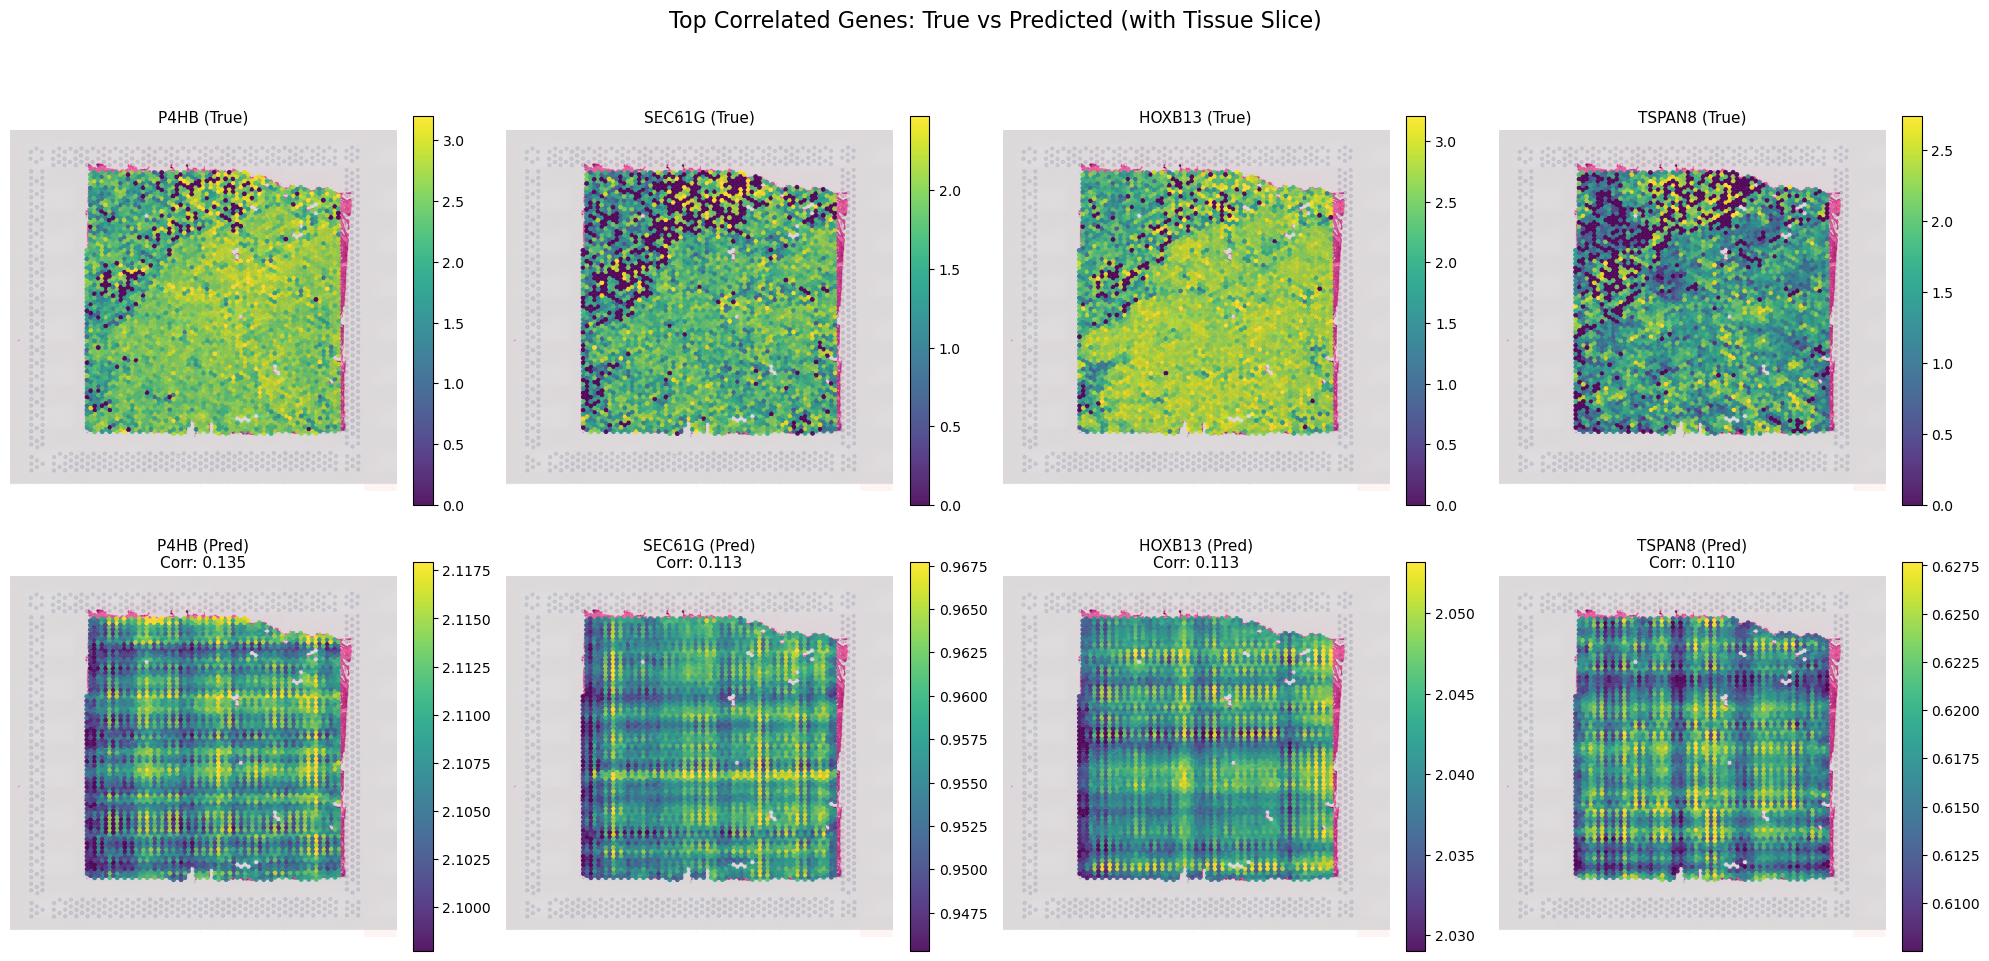

In [9]:
# === Visualizing Spatial Gene-Expression (Top-4) WITH Tissue Slice Background ===
import os
from pathlib import Path

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# Optional: background loading
from PIL import Image


def robust_vmin_vmax(arr, p_low=1, p_high=99):
    """
    Compute (vmin, vmax) from *this panel's* values only (robust percentiles).
    Each panel (each subplot) can have its own scale.
    """
    a = np.asarray(arr, dtype=float)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return 0.0, 1.0

    vmin, vmax = np.percentile(a, [p_low, p_high])
    if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
        vmin, vmax = float(np.min(a)), float(np.max(a))
        if vmin == vmax:
            eps = 1e-6 if vmin == 0 else abs(vmin) * 1e-6
            vmin, vmax = vmin - eps, vmax + eps
    return vmin, vmax


# ----------------------------
# 0) Paths & IDs
# ----------------------------
TEST_ID = "INT28"

ROOT = Path(os.environ.get("MORPHO_VC_ROOT", "../")).expanduser().resolve()
DATA_DIR = ROOT / "data" / "spatial_data"
HEST_DIR = ROOT / "data" / "hest_data"

h5ad_path = DATA_DIR / f"{TEST_ID}.h5ad"
if not h5ad_path.exists():
    # fallback (keep your style)
    h5ad_path = Path(f"../../data/spatial_data/{TEST_ID}.h5ad").resolve()

print(f"Loading spatial data from: {h5ad_path}")

# ----------------------------
# 1) Load spatial coords
# ----------------------------
try:
    adata = sc.read_h5ad(h5ad_path)
    coords = adata.obsm["spatial"]  # shape (N, 2)
    x, y = coords[:, 0], coords[:, 1]

    min_x, min_y = coords.min(axis=0)
    max_x, max_y = coords.max(axis=0)
    print(f"Coords Range: X[{min_x:.1f}, {max_x:.1f}], Y[{min_y:.1f}, {max_y:.1f}]")
except Exception as e:
    print(f"[ERROR] Failed to load spatial coords: {e}")
    # last-resort fallback for debugging
    x, y = np.random.rand(pred_bag.shape[0]), np.random.rand(pred_bag.shape[0])
    min_x, min_y, max_x, max_y = x.min(), y.min(), x.max(), y.max()

# ----------------------------
# 2) Try load WSI background (tissue slice)
# ----------------------------
bg_img = None
bg_extent = None  # (xmin, xmax, ymax, ymin) or (xmin, xmax, ymin, ymax) depending on usage

wsi_files = list((HEST_DIR / "wsis").glob(f"{TEST_ID}.*"))
if len(wsi_files) > 0:
    wsi_path = wsi_files[0]
    print(f"Found WSI: {wsi_path}")

    # Try OpenSlide first (best for .svs/.tiff)
    try:
        import openslide  # noqa: F401

        slide = openslide.OpenSlide(str(wsi_path))
        w0, h0 = slide.dimensions
        print(f"WSI dims (original): {w0} x {h0}")

        # build a thumbnail for plotting speed
        thumb_w = 2000
        scale = thumb_w / w0
        thumb_h = int(h0 * scale)
        bg_img = slide.get_thumbnail((thumb_w, thumb_h))

        # Decide extent strategy:
        # If coords look like they live in pixel space [0..w0, 0..h0], use pixel extent.
        # Else, stretch thumbnail into coords bounding box (still gives a tissue-context background).
        in_pixel_space = (
            (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
            (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
        )

        if in_pixel_space:
            # same convention as your reference code: y-down image coordinates
            bg_extent = (0, w0, h0, 0)
            print("Using pixel-space extent (0..W, H..0) for alignment.")
        else:
            bg_extent = (min_x, max_x, max_y, min_y)
            print("Coords not in pixel space; stretching background to coords bounding box.")

    except Exception as e:
        print(f"OpenSlide failed ({e}), trying PIL...")

        try:
            Image.MAX_IMAGE_PIXELS = None
            img = Image.open(wsi_path)
            w0, h0 = img.size
            print(f"WSI dims (PIL original): {w0} x {h0}")

            img.thumbnail((2000, 2000))
            bg_img = img

            in_pixel_space = (
                (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
                (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
            )
            if in_pixel_space:
                bg_extent = (0, w0, h0, 0)
                print("Using pixel-space extent (0..W, H..0) for alignment.")
            else:
                bg_extent = (min_x, max_x, max_y, min_y)
                print("Coords not in pixel space; stretching background to coords bounding box.")
        except Exception as e2:
            print(f"[WARNING] PIL background load failed: {e2}")
            bg_img, bg_extent = None, None
else:
    print("[INFO] No WSI found under:", (HEST_DIR / "wsis"))

# ----------------------------
# 3) Pick Top-4 genes by correlation (valid: list of (idx, corr))
# ----------------------------
sorted_genes = sorted(valid, key=lambda t: t[1], reverse=True)
top4_genes = sorted_genes[:4]
n_show = len(top4_genes)
if n_show == 0:
    raise ValueError("top4_genes is empty. Check `valid` content.")

# ----------------------------
# 4) Plot (2 rows: True vs Pred) + background slice
#    - ✅ NO shared scaling: each panel (each subplot) has its own vmin/vmax
# ----------------------------
fig, axes = plt.subplots(2, n_show, figsize=(5 * n_show, 10))
if n_show == 1:
    # keep axes 2D: axes[row, col]
    axes = np.array(axes).reshape(2, 1)

fig.suptitle("Top Correlated Genes: True vs Predicted (with Tissue Slice)", fontsize=16, y=0.98)

for i, (gene_idx, corr) in enumerate(top4_genes):
    gene_name = common_genes[gene_idx]

    gt_expr = true_bag[:, gene_idx]
    pr_expr = pred_bag[:, gene_idx]

    # ✅ Panel-wise dynamic range (robust to outliers)
    vmin_gt, vmax_gt = robust_vmin_vmax(gt_expr, p_low=1, p_high=99)
    vmin_pr, vmax_pr = robust_vmin_vmax(pr_expr, p_low=1, p_high=99)

    # --- Row 1: Ground Truth ---
    ax_gt = axes[0, i]
    if bg_img is not None and bg_extent is not None:
        ax_gt.imshow(bg_img, extent=bg_extent)
    sc_gt = ax_gt.scatter(
        x, y, c=gt_expr, cmap="viridis", s=12, alpha=0.9,
        vmin=vmin_gt, vmax=vmax_gt, edgecolors="none"
    )
    ax_gt.set_title(f"{gene_name} (True)", fontsize=11)
    ax_gt.axis("off")
    if bg_img is None:
        ax_gt.invert_yaxis()
    plt.colorbar(sc_gt, ax=ax_gt, fraction=0.046, pad=0.04)

    # --- Row 2: Prediction ---
    ax_pr = axes[1, i]
    if bg_img is not None and bg_extent is not None:
        ax_pr.imshow(bg_img, extent=bg_extent)
    sc_pr = ax_pr.scatter(
        x, y, c=pr_expr, cmap="viridis", s=12, alpha=0.9,
        vmin=vmin_pr, vmax=vmax_pr, edgecolors="none"
    )
    ax_pr.set_title(f"{gene_name} (Pred)\nCorr: {corr:.3f}", fontsize=11)
    ax_pr.axis("off")
    if bg_img is None:
        ax_pr.invert_yaxis()
    plt.colorbar(sc_pr, ax=ax_pr, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
